In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/CAKHJ_41LRE?si=VHeZfAQdid9ZNr_i" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

This notebook trains a very tiny convolutional neural network on the MNIST dataset and generates a CircuitPython compatible library that can be used to perform inference on a microcontroller. Checkout the article on my website which had detailed explanation on how this works. It should also help you train your own neural networks and port them to CircuitPython.

If you are curious as to why CircuitPython (and not TFLite), please read this article. For instructions on assembling the circuit and running the code on the Raspberry Pi Pico, please check out this article.

## Loading the dataset

> Note: We resize images to 30x30. Larger image means more data and less noise. Very helpful when working with cameras

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_images = tf.image.resize(train_images, [30, 30])
test_images = tf.image.resize(test_images, [30, 30])

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)


2024-06-29 04:44:45.623543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 04:44:45.623705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 04:44:45.787514: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Creating a lightweight CNN

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(30, 30, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(2, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 2)      │           146 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,116 (12.17 KB)

 Trainable params: 3,116 (12.17 KB)

 Non-trainable params: 0 (0.00 B)

Keep training till you get desired accuracy. Feel free to experiment by modifying parameters and epochs in below code

In [5]:
history = model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7001 - loss: 0.9542 - val_accuracy: 0.9068 - val_loss: 0.3218
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9053 - loss: 0.3235 - val_accuracy: 0.9434 - val_loss: 0.2058
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9410 - loss: 0.1998 - val_accuracy: 0.9570 - val_loss: 0.1527
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9559 - loss: 0.1448 - val_accuracy: 0.9632 - val_loss: 0.1317
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9627 - loss: 0.1277 - val_accuracy: 0.9666 - val_loss: 0.1191


In [6]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9613 - loss: 0.1199
Test accuracy: 0.9678000211715698


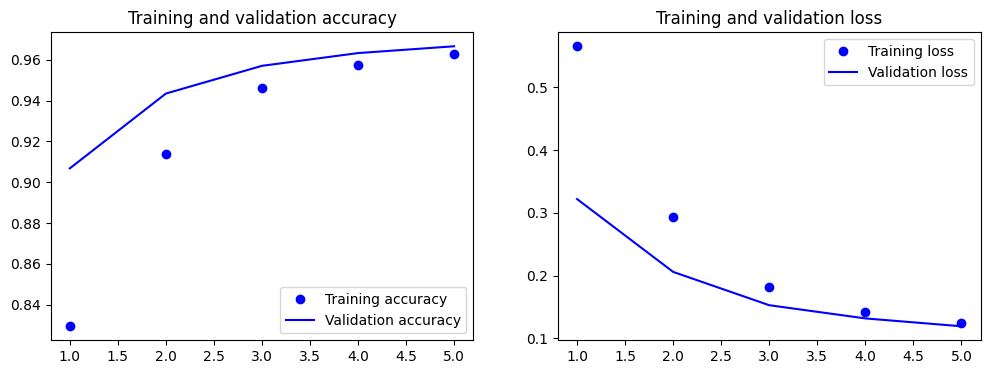

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)



plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## Exporting weights and biases for every layer

The below code simply outputs variable declartions to a text file in python variable declartion syntax. Simply copy these weights and paste them in `mnist_clf.py`. Once that is done you need to generate a `mnist_clf.mpy` file using [mpy-cross](https://adafruit-circuit-python.s3.amazonaws.com/index.html?prefix=bin/mpy-cross/) tool. You can read more about `mpy` files and `mpy-cross` [here](https://learn.adafruit.com/welcome-to-circuitpython/library-file-types-and-frozen-libraries).

The Github repository for the project also contains detailed instructions on training your own model and using the weights: xxxxxx

In [8]:
import numpy as np

weights = {}
np.set_printoptions(threshold=np.inf)

with open("mnist_weights.py.txt", "w") as f:
    f.write("# Overwrite the variable declarations in mnist_clf.py with below declarations\n")
    f.write("# Once mnist_clf.py file is generated, create the mnist_clf.mpy using mpy-cross\n")
    f.write("# For more information visit:\n")
    f.write("\n")
    for i, layer in enumerate(model.layers):
        if i == 0:
            weights = layer.get_weights()
            weights_0 = [weights[0][:, :, 0, i] for i in range(weights[0].shape[3])]
            f.write(f"weights_0 = {repr(weights_0)}\n")
            f.write(f"biases_0 = {repr(weights[1])}\n")
            
        if i == 2:
            weights = layer.get_weights()
            weights_1 = [[weights[0][:, :, k, f] for k in range(8)] for f in range(2)]
            f.write(f"weights_1 = {repr(weights_1)}\n")
            f.write(f"biases_1 = {repr(weights[1])}\n")
            
        if i == 4:
            weights = layer.get_weights()
            f.write(f"weights_2 = {repr(weights[0])}\n")
            f.write(f"biases_2 = {repr(weights[1])}\n")
            
print("Done writing weights !")

Done writing weights !


## Exporting outputs for known inputs (for validating our implementation)

The code given below generates images with known patterns and outputs the classifier's predictions. For each usecase, you can run the `verify.py` file on the CircuitPython board to check if the classifier's output on your computer match those on the board.

In [9]:
import numpy as np

def create_pattern(pattern_type):
    if pattern_type == '1010':
        pattern = np.array([[1, 0] * 15] * 30) 
    elif pattern_type == '1111':
        pattern = np.ones((30, 30))
    elif pattern_type == '0101':
        pattern = np.array([[0, 1] * 15] * 30)  
    elif pattern_type == '1100':
        pattern = np.array([[1, 1, 0, 0] * 7 + [1, 1]] * 30)
    else:
        raise ValueError("Unknown pattern type")
    
    return pattern.reshape(30, 30)

def perform_inference(model, pattern):
    pattern = pattern.reshape(1, 30, 30, 1).astype('float32')    
    output = model.predict(pattern)
    
    return output

# List of pattern types
pattern_types = ['1010', '1111', '0101', '1100']

# Open file to write results
with open("validation_results.py.txt", "w") as f:
    f.write("# Results of predictions\n\n")
    for i, pattern_type in enumerate(pattern_types):
        pattern = create_pattern(pattern_type)
        output = perform_inference(model, pattern)
        f.write(f"result_{i} = {output[0].tolist()}\n")
        f.write("\n")

print("Results written to results.py")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Results written to results.py


## Generating the classifier module for CircuitPython

In [10]:
import requests

# Step 1: Download the template file from the URL
url = "https://raw.githubusercontent.com/code2k13/cnn_circuit_python/main/mnist_clf_template.py.txt"
response = requests.get(url)
downloaded_file_path = "downloaded_file.txt"

with open(downloaded_file_path, 'wb') as f:
    f.write(response.content)

print(f"Template file downloaded and saved as {downloaded_file_path}")

# Paths for the files to be inserted
weights_file_path = "mnist_weights.py.txt"
validation_file_path = "validation_results.py.txt"

# Step 2: Read content from the files to be inserted
with open(weights_file_path, 'r') as f:
    weights_content = f.read()
    weights_content = weights_content.replace("array","np.array")
    weights_content = weights_content.replace("float32","np.float")

with open(validation_file_path, 'r') as f:
    validation_content = f.read()

# Step 3: Insert content into the template
with open(downloaded_file_path, 'r') as f:
    template_content = f.read()

# Insert weights content
template_content = template_content.replace(
    "##### weights sections starts #####\n\n##### weights sections ends #####",
    f"##### weights sections starts #####\n{weights_content}\n##### weights sections ends #####"
)

# Insert validation content
template_content = template_content.replace(
    "##### validation sections starts #####\n\n##### validation sections ends #####",
    f"##### validation sections starts #####\n{validation_content}\n##### validation sections ends #####"
)

# Save the modified template
output_file_path = "mnist_clf.py"
with open(output_file_path, 'w') as f:
    f.write(template_content)

print(f"Modified template saved as {output_file_path}")


Template file downloaded and saved as downloaded_file.txt
Modified template saved as mnist_clf.py


## Validate our code

In [11]:
import shutil

src_file = 'mnist_clf.py'
dst_file = 'mnist_clf_pc.py'

with open(src_file, 'r') as src:
    with open(dst_file, 'w') as dst:
        for line in src:
            # Modify the first line if necessary
            if 'from ulab import numpy as np' in line:
                modified_line = line.replace('from ulab import numpy as np', 'import numpy as np')
            else:
            #    # Modify any occurrence of np.float to np.float32
                modified_line = line.replace('np.float)', 'np.float32)')

            dst.write(modified_line)

print(f"Successfully copied and modified {src_file} to {dst_file}.")


Successfully copied and modified mnist_clf.py to mnist_clf_pc.py.


In [12]:
import importlib
mnist_clf_pc = importlib.import_module('mnist_clf_pc')
importlib.reload(mnist_clf_pc)
output = mnist_clf_pc.validate()
if output:
    print("All OK !")
else:
    print("Error!")

All OK !


## Converting the module to mpy (Freezing the module)

⚠️ You may have to modify the `url` to download `mpy-cross` for your operating system. Here is list of `mpy-cross` binaries for all operating systems : https://adafruit-circuit-python.s3.amazonaws.com/index.html?prefix=bin/mpy-cross/

In [13]:
import os
import requests
import subprocess

# URL to download mpy-cross
url = "https://adafruit-circuit-python.s3.amazonaws.com/bin/mpy-cross/mpy-cross.static-amd64-linux-8.0.5"

# File path to save mpy-cross
mpy_cross_path = "./mpy-cross"

# Download mpy-cross
response = requests.get(url)
if response.status_code == 200:
    with open(mpy_cross_path, "wb") as f:
        f.write(response.content)
    print("mpy-cross downloaded successfully.")
else:
    print(f"Failed to download mpy-cross. Status code: {response.status_code}")

# Make mpy-cross executable
os.chmod(mpy_cross_path, 0o755)
print("mpy-cross made executable.")

# Run mpy-cross and print output
try:
    output = subprocess.check_output([mpy_cross_path,"mnist_clf.py"], stderr=subprocess.STDOUT)
    print(output.decode('utf-8'))
except subprocess.CalledProcessError as e:
    print(f"Error running mpy-cross: {e.output.decode('utf-8')}")

mpy-cross downloaded successfully.
mpy-cross made executable.



Done ! Download and copy the `mnist_clf.mpy` file to your CircuitPython board. Please make sure that you use CircuitPython 8